# Explore half-hourly dataset

We will explore a half-hourly GPP dataset with ground measurements of GPP, climate variables (e.g. temperature, VPD, precipitation), as well as satellite observations (surface reflectance, vegetation indexes). The data were collected from flux tower sites across the world. These are the same sites as in the monthly dataset.

## Science background and questions
Plant physiology processes, such as photosynthesis, changes in response to concurrent environmental factors. Photosynthesis (GPP) has both diurnal and seasonal cycles, mostly triggered by change of solar radiation and temperature within the day and across seasons. For example, solar radiation and temperature normally increases from early morning, reaches the highest around noon or slightly after, and decreases in the afternoon through evening and night. Moreover, plants can also have memories of past experiences, usually due to recurrent environmental stress, which prepares them for future stressful conditions. This plant memory can both be short (i.e. within 24 hours) or long term (i.e. months or years). When this happens, plant photosynthesis can also be affected by past climate and environmental conditions. In this project, we want to model both GPP responses to both present and past environmental stimuli with sequential deep neural networks such as LSTM and Transformer. We will test whether considering sequential information can improve models’ predictive performance of GPP when benchmarked with regular models (e.g. random forest) with only concurrent inputs.

## Objectives
* Benchmark LSTM and other ML Models (Lasso, SVM, RF, XGBoost, MLP) for predicting hourly data
* Compare models for different sites of different PFTs

# Load Packages

In [65]:
import pandas as pd
import numpy as np
import seaborn as sns                       #visualisation
import matplotlib.pyplot as plt             #visualisation
%matplotlib inline     
sns.set(color_codes=True)

In [66]:
import pandas as pd
import numpy as np
import seaborn as sns                       #visualisation
import matplotlib.pyplot as plt             #visualisation
%matplotlib inline     
sns.set(color_codes=True)

#modeling

from xgboost import XGBRegressor 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, RidgeCV
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.model_selection import StratifiedGroupKFold, GridSearchCV, GroupKFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn import ensemble
from sklearn import neighbors
from sklearn.metrics import mean_squared_error 
from math import sqrt
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer


The half-hourly data is saved as separate files per site. Each row in the data contains a GPP observation (“GPP_NT_VUT_REF”), atmospheric observations (half-hourly), and satellite observations (daily) for a half-hour time periods (TIMESTAMP_START, TIMESTAMP_END). 

**Target**: GPP_NT_VUT_REF  
**Features**: 
* Climate: 
  * “TA_ERA” (air temperature)
  * “P_ERA” (precipitation)
  * “VPD_ERA” (VPD)
  * “SW_IN_ERA” (solar radiation)
* Satellite
  * “b1”, “b2”, “b3”, “b4”, “b5”, “b6”, “b7”, “NDVI”, “EVI”, “NIRv”
* Categorical
  * “IGBP”
  * “Koppen”

The whole dataset exceeds 15 GB, which will not fit in memory of the colab hardware. So in this notebook, we will explore data for selected sites.

### Check the list of sites

In [67]:
site_path = '/global/scratch/users/yaqiantang/discoveryData/' + \
 'site_summary_v0_3_2.csv'
site_summary = pd.read_csv(site_path)
site_summary.head()

,SITE_ID,dataset,start_year,end_year,path,dup,IGBP,LOCATION_ELEV,LOCATION_LAT,LOCATION_LONG,SITE_NAME,koppen_sub,koppen_main,koppen_name,koppen_main_name,C3/C4,C4_percent
0,AR-SLu,FLUXNET,2009,2011,/Users/yanghuikang/Documents/Work/Research/Dat...,False,MF,NaN,-33.46480,-66.4598,San Luis,7,2,BSk,Arid,C3,67.08
1,AR-Vir,FLUXNET,2009,2012,/Users/yanghuikang/Documents/Work/Research/Dat...,False,ENF,NaN,-28.23950,-56.1886,Virasoro,14,3,Cfa,Temperate,C3,8.75
2,AT-Neu,FLUXNET,2002,2012,/Users/yanghuikang/Documents/Work/Research/Dat...,False,GRA,970.0,47.11667,11.3175,Neustift,26,4,Dfb,Cold,C3,0.00
3,AU-ASM,FLUXNET,2010,2014,/Users/yanghuikang/Documents/Work/Research/Dat...,False,SAV,NaN,-22.28300,133.2490,Alice Springs,4,2,BWh,Arid,C3,100.00
4,AU-Ade,FLUXNET,2007,2009,/Users/yanghuikang/Documents/Work/Research/Dat...,False,WSA,NaN,-13.07690,131.1178,Adelaide River,3,1,Aw,Tropical,C3,79.57


Print a list of site ID for each IGBP category:  
Check here for descriptions of the IGBP classification https://fluxnet.org/data/badm-data-templates/igbp-classification/  
Note that not all of the sites are in the half-hourly dataset.

In [68]:
with pd.option_context('display.max_colwidth', None):
    display(site_summary.groupby('IGBP')['SITE_ID'].apply(list))

IGBP
CRO                                                                                                                                                                                                                                                                                                                                    [DE-Seh, DK-Fou, FI-Jok, IT-CA2, US-Lin, US-Ne1, US-Ne2, US-Ne3, US-Tw3, US-Twt, US-ARM, US-Bi1, US-Bi2, US-CRT, US-Ro1, US-Ro5, US-Ro6, US-Tw2, US-Wgr, BE-Lon, CH-Oe2, CZ-KrP, DE-Geb, DE-Kli, DE-RuS, FI-Qvd, FR-Aur, FR-Gri, FR-Lam, IT-BCi, FR-EM2, SE-Lnn]
CSH                                                                                                                                                                                                                                                                                                                                                                                                                        

In [69]:
data_path = '/global/scratch/users/yaqiantang/discoveryData/'

# ML Models Development

# 5th site - GRA: US-Var

In [70]:
site_id = 'US-Var' # 
df = pd.read_csv(data_path + 'data_full_half_hourly_raw_v0_1_' + site_id + '.csv')
df.head()

,TIMESTAMP_START,TIMESTAMP_END,TA_F,TA_F_QC,TA_ERA,SW_IN_POT,SW_IN_F,SW_IN_F_QC,SW_IN_ERA,LW_IN_F,...,NIRv,b1,b2,b3,b4,b5,b6,b7,IGBP,koppen
0,200011010000,200011010030,8.59,0,8.117,0.0,0.0,0,0.0,297.554,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GRA,Temperate
1,200011010030,200011010100,8.54,0,7.898,0.0,0.0,0,0.0,297.554,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GRA,Temperate
2,200011010100,200011010130,8.51,0,7.680,0.0,0.0,0,0.0,277.808,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GRA,Temperate
3,200011010130,200011010200,8.07,0,7.353,0.0,0.0,0,0.0,277.808,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GRA,Temperate
4,200011010200,200011010230,7.43,0,7.027,0.0,0.0,0,0.0,277.808,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GRA,Temperate


In [71]:
target = 'GPP_NT_VUT_REF'
features = ['year','TA_ERA','SW_IN_ERA','P_ERA','VPD_ERA','b1','b2','b3','b4','b5','b6',
            'b7','NDVI','EVI','NIRv']
# and categorical features: IGBP and koppen

df['datetime'] = pd.to_datetime(df['datetime'])
df = df.set_index('datetime')
df.head()

,TIMESTAMP_START,TIMESTAMP_END,TA_F,TA_F_QC,TA_ERA,SW_IN_POT,SW_IN_F,SW_IN_F_QC,SW_IN_ERA,LW_IN_F,...,NIRv,b1,b2,b3,b4,b5,b6,b7,IGBP,koppen
datetime,,,,,,,,,,,,,,,,,,,,,
2000-11-01 00:00:00,200011010000,200011010030,8.59,0,8.117,0.0,0.0,0,0.0,297.554,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GRA,Temperate
2000-11-01 00:30:00,200011010030,200011010100,8.54,0,7.898,0.0,0.0,0,0.0,297.554,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GRA,Temperate
2000-11-01 01:00:00,200011010100,200011010130,8.51,0,7.680,0.0,0.0,0,0.0,277.808,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GRA,Temperate
2000-11-01 01:30:00,200011010130,200011010200,8.07,0,7.353,0.0,0.0,0,0.0,277.808,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GRA,Temperate
2000-11-01 02:00:00,200011010200,200011010230,7.43,0,7.027,0.0,0.0,0,0.0,277.808,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GRA,Temperate


In [72]:
# One hot encoding categorical variables: IGBP and Koppen
df_ohe = df[[target, 'IGBP', 'koppen'] + features]

categorical_columns = ['IGBP', 'koppen']
for col in categorical_columns:
    col_ohe = pd.get_dummies(df[col], prefix=col)
    df_ohe = pd.concat((df_ohe, col_ohe), axis=1).drop(col, axis=1)

df_ohe.columns

Index(['GPP_NT_VUT_REF', 'year', 'TA_ERA', 'SW_IN_ERA', 'P_ERA', 'VPD_ERA',
       'b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7', 'NDVI', 'EVI', 'NIRv',
       'IGBP_GRA', 'koppen_Temperate'],
      dtype='object')

In [73]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    return df

In [74]:
# clean the data.
df = clean_dataset(df_ohe)
df.head()

,GPP_NT_VUT_REF,year,TA_ERA,SW_IN_ERA,P_ERA,VPD_ERA,b1,b2,b3,b4,b5,b6,b7,NDVI,EVI,NIRv,IGBP_GRA,koppen_Temperate
datetime,,,,,,,,,,,,,,,,,,
2001-01-01 00:00:00,-1.84180,2001,2.171,0.0,0.0,0.893,0.0628,0.2694,0.0304,0.0625,0.3155,0.2595,0.1311,0.621915,0.364194,0.167544,1,1
2001-01-01 00:30:00,-1.91023,2001,2.161,0.0,0.0,1.107,0.0628,0.2694,0.0304,0.0625,0.3155,0.2595,0.1311,0.621915,0.364194,0.167544,1,1
2001-01-01 01:00:00,-1.85277,2001,2.150,0.0,0.0,1.321,0.0628,0.2694,0.0304,0.0625,0.3155,0.2595,0.1311,0.621915,0.364194,0.167544,1,1
2001-01-01 01:30:00,-5.84140,2001,2.044,0.0,0.0,1.391,0.0628,0.2694,0.0304,0.0625,0.3155,0.2595,0.1311,0.621915,0.364194,0.167544,1,1
2001-01-01 02:00:00,-2.51478,2001,1.938,0.0,0.0,1.461,0.0628,0.2694,0.0304,0.0625,0.3155,0.2595,0.1311,0.621915,0.364194,0.167544,1,1


In [75]:
# test train split grouped by year
from sklearn.model_selection import GroupShuffleSplit 

splitter = GroupShuffleSplit(test_size=0.3, n_splits=2, random_state = 42)
split = splitter.split(df, groups=df['year'])
train_inds, test_inds = next(split)

train_df = df.iloc[train_inds]
test_df = df.iloc[test_inds]

In [76]:
train_df.head(2)

,GPP_NT_VUT_REF,year,TA_ERA,SW_IN_ERA,P_ERA,VPD_ERA,b1,b2,b3,b4,b5,b6,b7,NDVI,EVI,NIRv,IGBP_GRA,koppen_Temperate
datetime,,,,,,,,,,,,,,,,,,
2002-01-09 00:00:00,-0.556452,2002,7.249,0.0,0.0,0.976,0.0641,0.263,0.0315,0.0688,0.2799,0.2591,0.1309,0.608071,0.352322,0.159923,1,1
2002-01-09 00:30:00,-0.562734,2002,6.956,0.0,0.0,0.933,0.0641,0.263,0.0315,0.0688,0.2799,0.2591,0.1309,0.608071,0.352322,0.159923,1,1


In [77]:
test_df.head(2)

,GPP_NT_VUT_REF,year,TA_ERA,SW_IN_ERA,P_ERA,VPD_ERA,b1,b2,b3,b4,b5,b6,b7,NDVI,EVI,NIRv,IGBP_GRA,koppen_Temperate
datetime,,,,,,,,,,,,,,,,,,
2001-01-01 00:00:00,-1.84180,2001,2.171,0.0,0.0,0.893,0.0628,0.2694,0.0304,0.0625,0.3155,0.2595,0.1311,0.621915,0.364194,0.167544,1,1
2001-01-01 00:30:00,-1.91023,2001,2.161,0.0,0.0,1.107,0.0628,0.2694,0.0304,0.0625,0.3155,0.2595,0.1311,0.621915,0.364194,0.167544,1,1


In [78]:
train_df['year'].value_counts()

2007    17520
2009    17520
2011    17472
2008    17184
2003    17136
2002    17040
2004    16992
2014    16896
2005    15216
Name: year, dtype: int64

In [79]:
test_df['year'].value_counts()

2012    17568
2013    17520
2006    17376
2001    17136
2010    16176
Name: year, dtype: int64

In [80]:
X_train = train_df.drop([target, 'year'], axis = 1)
X_train.head(2)

,TA_ERA,SW_IN_ERA,P_ERA,VPD_ERA,b1,b2,b3,b4,b5,b6,b7,NDVI,EVI,NIRv,IGBP_GRA,koppen_Temperate
datetime,,,,,,,,,,,,,,,,
2002-01-09 00:00:00,7.249,0.0,0.0,0.976,0.0641,0.263,0.0315,0.0688,0.2799,0.2591,0.1309,0.608071,0.352322,0.159923,1,1
2002-01-09 00:30:00,6.956,0.0,0.0,0.933,0.0641,0.263,0.0315,0.0688,0.2799,0.2591,0.1309,0.608071,0.352322,0.159923,1,1


In [81]:
y_train = train_df[target]
y_train.head(2)

datetime
2002-01-09 00:00:00   -0.556452
2002-01-09 00:30:00   -0.562734
Name: GPP_NT_VUT_REF, dtype: float64

In [82]:
X_test = test_df.drop([target, 'year'], axis = 1)
X_test.head(2)

,TA_ERA,SW_IN_ERA,P_ERA,VPD_ERA,b1,b2,b3,b4,b5,b6,b7,NDVI,EVI,NIRv,IGBP_GRA,koppen_Temperate
datetime,,,,,,,,,,,,,,,,
2001-01-01 00:00:00,2.171,0.0,0.0,0.893,0.0628,0.2694,0.0304,0.0625,0.3155,0.2595,0.1311,0.621915,0.364194,0.167544,1,1
2001-01-01 00:30:00,2.161,0.0,0.0,1.107,0.0628,0.2694,0.0304,0.0625,0.3155,0.2595,0.1311,0.621915,0.364194,0.167544,1,1


In [83]:
y_test = test_df[target]
y_test.head(2)

datetime
2001-01-01 00:00:00   -1.84180
2001-01-01 00:30:00   -1.91023
Name: GPP_NT_VUT_REF, dtype: float64

In [84]:
print ("train_X.shape" , X_train.shape) 
print ("train_y.shape" , y_train.shape)
print ("test_X.shape" , X_test.shape) 
print ("test_y.shape" , y_test.shape)

train_X.shape (152976, 16)
train_y.shape (152976,)
test_X.shape (85776, 16)
test_y.shape (85776,)


In [85]:
# Function to standardize variables and create test/train split 
'''
def get_train_test_split(df, test_size, random_state, neural_net=False):
    """
    This function returns four dataframes containing the testing and training X and y values.
    Input:
        df: df that contains the target/response variable and all the features.
        y_col: a column name (as a string) of df that represents the response variable
        test_size: a float between 0 and 1 indicating the fraction of the data to include in the test split
        random_state: an integer, used to define the random state,
        neural_net: boolean if making split for neural network model to determine how we should standardize 
    Output: X_train, X_test, y_train, y_test, four dataframes containing the training and testing subsets of the 
    feature matrix X and response matrix y
    """
    
    X = df[['GPP_NT_VUT_REF', 'TA_ERA', 'SW_IN_ERA', 'P_ERA', 'VPD_ERA', 'b1', 'b2',
       'b3', 'b4', 'b5', 'b6', 'b7', 'NDVI', 'EVI', 'NIRv', 'IGBP_GRA',
       'koppen_Temperate']]
    y = df[target]
    
    # Standardize the data
    if not neural_net:
        scaler = StandardScaler()
        scaler.fit(X) 
        X_stnd = scaler.transform(X)
    else:
        scaler = MinMaxScaler(feature_range=(0, 1))
        X_stnd = scaler.fit_transform(X)
    
    X_train, X_test, y_train, y_test = train_test_split(X_stnd, y, test_size=test_size, 
                                                        random_state=random_state, shuffle=True)
    
    return X_train, X_test, y_train, y_test, scaler
    
'''

'\ndef get_train_test_split(df, test_size, random_state, neural_net=False):\n    """\n    This function returns four dataframes containing the testing and training X and y values.\n    Input:\n        df: df that contains the target/response variable and all the features.\n        y_col: a column name (as a string) of df that represents the response variable\n        test_size: a float between 0 and 1 indicating the fraction of the data to include in the test split\n        random_state: an integer, used to define the random state,\n        neural_net: boolean if making split for neural network model to determine how we should standardize \n    Output: X_train, X_test, y_train, y_test, four dataframes containing the training and testing subsets of the \n    feature matrix X and response matrix y\n    """\n    \n    X = df[[\'GPP_NT_VUT_REF\', \'TA_ERA\', \'SW_IN_ERA\', \'P_ERA\', \'VPD_ERA\', \'b1\', \'b2\',\n       \'b3\', \'b4\', \'b5\', \'b6\', \'b7\', \'NDVI\', \'EVI\', \'NIRv\', \

In [86]:
#X_train, X_test, y_train, y_test, scaler = get_train_test_split(df, 0.3, 2022)

### Lasso

In [87]:
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=2022)

lasso_model = LassoCV(cv = kf, alphas=np.linspace(0.001, 10, 100), max_iter = 10000)
lasso_model.fit(X_train, y_train)
print('Lasso Model Optimal Alpha: ', lasso_model.alpha_)

Lasso Model Optimal Alpha:  0.001


In [88]:
# Cross Validation Results

rmse = cross_val_score(lasso_model, X_train, y_train, scoring='neg_root_mean_squared_error', cv = kf)
r2 = cross_val_score(lasso_model, X_train, y_train, scoring='r2', cv = kf)

#get the mean of each fold 
print("RMSE: %.3f, Standard Deviation : %.3f" % (rmse.mean() * -1, rmse.std())) 
print("R2: %.3f, Standard Deviation : %.3f" % (r2.mean(), r2.std())) 

RMSE: 3.795, Standard Deviation : 0.041
R2: 0.427, Standard Deviation : 0.004


In [89]:
def calculate_errors(y_train, y_train_predicted, y_test, y_test_predicted, model_name):
  r2 = r2_score(y_test, y_test_predicted)
  rmse_train = np.sqrt(mean_squared_error(y_train, y_train_predicted))
  rmse_test = np.sqrt(mean_squared_error(y_test, y_test_predicted))
  bias_train = np.mean(y_train - y_train_predicted)
  bias_test = np.mean(y_test - y_test_predicted)
  print("The R2 score of " + model_name + " is: " + str(r2))
  print("The RMSE of predicting the TRAINING set of " + model_name + " is: " + str(rmse_train))
  print("The RMSE of predicting the TESTING set of " + model_name + " is: " + str(rmse_test))
  print("The bias of predicting the TRAINING set of " + model_name + " is: " + str(bias_train))
  print("The bias of predicting the TESTING set of " + model_name + " is: " + str(bias_test))
  return r2, rmse_test

def show_scatter_train(y_train, y_train_predicted, model_name):
  plt.figure(figsize=(8,5))
  plt.scatter(x = y_train, y = y_train_predicted)
  plt.plot(y_train, y_train, color = 'red', label = 'x=y')
  plt.title(model_name + " : observed vs. predicted for TRAIN set")
  plt.xlabel('y_train_Observed')
  plt.ylabel('y_train_Predicted');

def show_scatter_test(y_test, y_test_predicted, model_name):
  #plt.figure(figsize=(8,5))
  plt.scatter(x = y_test, y = y_test_predicted)
  plt.plot(y_test, y_test, color = 'red', label = 'x=y')
  plt.title(model_name + " : observed vs. predicted for TEST set")
  plt.xlabel('y_test_Observed')
  plt.ylabel('y_test_Predicted');

In [90]:
# Test Results

lasso_y_train_predicted = lasso_model.predict(X_train)
lasso_y_test_predicted = lasso_model.predict(X_test)
lasso_r2, lasso_rmse = calculate_errors(y_train, lasso_y_train_predicted, y_test, 
                                        lasso_y_test_predicted, "Lasso")

The R2 score of Lasso is: 0.3811854880815876
The RMSE of predicting the TRAINING set of Lasso is: 3.7951888079354408
The RMSE of predicting the TESTING set of Lasso is: 3.8263153656953484
The bias of predicting the TRAINING set of Lasso is: -4.459006813681206e-16
The bias of predicting the TESTING set of Lasso is: 0.1247717969990277


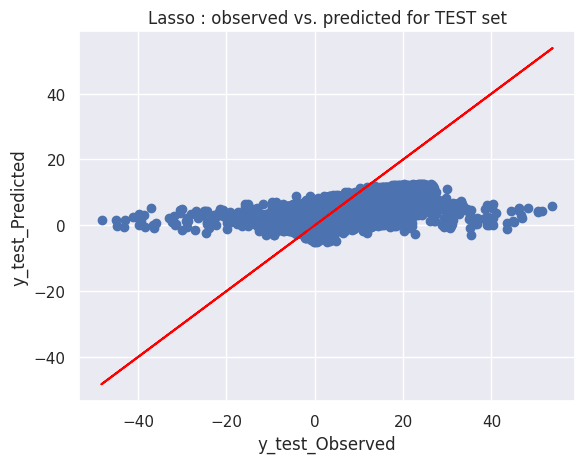

In [91]:
show_scatter_test(y_test, lasso_y_test_predicted, "Lasso")

### SVM

In [48]:
# NOTE: TAKES A LONG TIME TO RUN

# defining parameter range
svm_param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001],
              'kernel': ['rbf']} 
  
svm = SVR()
svm_random = RandomizedSearchCV(estimator = svm, param_distributions = svm_param_grid, 
                                scoring='neg_mean_squared_error', n_iter = 5, 
                                cv = kf, verbose=2, 
                                random_state=2022, n_jobs = -1)
# Fit the random search model
svm_random.fit(X_train, y_train)
# Print best parameters after tuning
print('SVM Best Parameters: ', svm_random.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


KeyboardInterrupt: 

In [ ]:
# Model with Cross Validated Hyperparameters
svm_model = SVR(kernel = 'rbf', gamma = 0.1, C = 10)
svm_model.fit(X_train, y_train)

In [ ]:
# Cross Validation Results

rmse = cross_val_score(svm_model, X_train, y_train, 
                       scoring='neg_root_mean_squared_error', cv = kf)
r2 = cross_val_score(svm_model, X_train, y_train, scoring='r2', cv = kf)

#get the mean of each fold 
print("RMSE: %.3f, Standard Deviation : %.3f" % (rmse.mean() * -1, rmse.std())) 
print("R2: %.3f, Standard Deviation : %.3f" % (r2.mean(), r2.std()))

In [ ]:
# Test Results
svm_y_train_predicted = svm_model.predict(X_train)
svm_y_test_predicted = svm_model.predict(X_test)
calculate_errors(y_train, svm_y_train_predicted, y_test, svm_y_test_predicted, "SVM")

In [ ]:
show_scatter_test(y_test, svm_y_test_predicted, "SVM")

### Random Forest


In [21]:
# Number of trees in random forest
n_estimators = [25, 50, 75, 100, 150, 200]
# Number of features to consider at every split
max_features = ['auto', 'sqrt', 0.1, 0.5, 1.0]
# Maximum number of levels in tree
max_depth = [3, 4, 5, 6]
# Minimum number of samples required to split a node
min_samples_split = [2,3,4,5,6]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2,3,4,5,6]
# Method of selecting samples for training each tree
bootstrap = [True, False]


# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestRegressor()
# Random search of parameters, using 5 fold cross validation, search across 10 different combinations
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, 
                               scoring='neg_mean_squared_error',n_iter = 10, cv = kf, verbose=2, 
                               random_state=2022, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)
# Print best parameters after tuning
print('Random Forest Best Parameters: ')
rf_random.best_params_

/global/home/users/yaqiantang/.conda/envs/ML/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/global/home/users/yaqiantang/.conda/envs/ML/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/global/home/users/yaqiantang/.conda/envs/ML/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set 

Random Forest Best Parameters: 


{'n_estimators': 200,
 'min_samples_split': 6,
 'min_samples_leaf': 6,
 'max_features': 0.5,
 'max_depth': 6,
 'bootstrap': True}

In [92]:
rf_model = RandomForestRegressor(n_estimators=200, min_samples_split=6, min_samples_leaf=6, 
                                 max_features=0.5, max_depth = 6, bootstrap = True)
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=6, max_features=0.5, min_samples_leaf=6,
                      min_samples_split=6, n_estimators=200)

In [23]:
# Cross Validation Results

rmse = cross_val_score(rf_model, X_train, y_train, scoring='neg_root_mean_squared_error', cv = kf)
r2 = cross_val_score(rf_model, X_train, y_train, scoring='r2', cv = kf)

#get the mean of each fold 
print("RMSE: %.3f, Standard Deviation : %.3f" % (rmse.mean() * -1, rmse.std())) 
print("R2: %.3f, Standard Deviation : %.3f" % (r2.mean(), r2.std())) 

[CV] END bootstrap=False, max_depth=6, max_features=0.5, min_samples_leaf=5, min_samples_split=5, n_estimators=50; total time=  21.8s
[CV] END bootstrap=False, max_depth=6, max_features=0.5, min_samples_leaf=5, min_samples_split=5, n_estimators=50; total time=  21.7s
[CV] END bootstrap=False, max_depth=6, max_features=0.5, min_samples_leaf=5, min_samples_split=5, n_estimators=50; total time=  21.9s
[CV] END bootstrap=False, max_depth=6, max_features=0.5, min_samples_leaf=5, min_samples_split=5, n_estimators=50; total time=  22.2s
[CV] END bootstrap=True, max_depth=4, max_features=0.5, min_samples_leaf=3, min_samples_split=4, n_estimators=75; total time=  16.0s
[CV] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=25; total time=   8.2s
[CV] END bootstrap=True, max_depth=4, max_features=0.5, min_samples_leaf=3, min_samples_split=4, n_estimators=75; total time=  16.1s
[CV] END bootstrap=True, max_depth=3, max_features=auto, min_sam

In [93]:
# Train/Test Results

rf_y_train_predicted = rf_model.predict(X_train)
rf_y_test_predicted = rf_model.predict(X_test)
rf_r2, rf_rmse = calculate_errors(y_train, rf_y_train_predicted, 
                                  y_test, rf_y_test_predicted, "Random Forest")

The R2 score of Random Forest is: 0.7321772648957846
The RMSE of predicting the TRAINING set of Random Forest is: 2.091361563003832
The RMSE of predicting the TESTING set of Random Forest is: 2.517237757339618
The bias of predicting the TRAINING set of Random Forest is: 0.0012741960779297605
The bias of predicting the TESTING set of Random Forest is: 0.1235870364697231


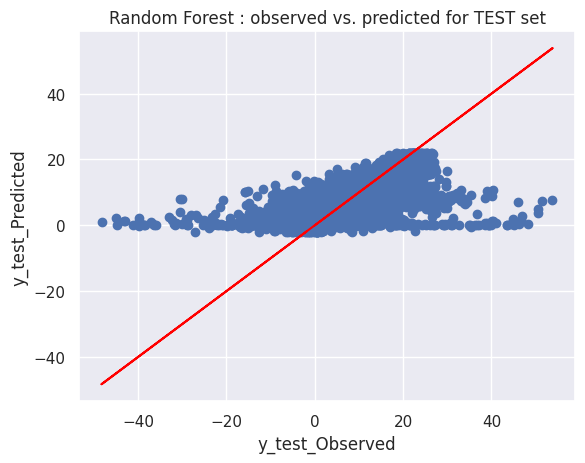

In [94]:
show_scatter_test(y_test, rf_y_test_predicted, "Random Forest")

## XGBoost

In [26]:
xgb_param_grid = { 'max_depth': [3, 5, 6, 10], 
                  'min_child_weight': [1, 3, 5, 7],
                  'learning_rate': [0.01, 0.1, 0.2, 0.3],
                  'subsample': np.arange(0.5, 1.0, 0.1),
                  'colsample_bytree': np.arange(0.4, 1.0, 0.1),
                  'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
                  'n_estimators': [50, 100, 150, 200, 250]}

xgbr = XGBRegressor()
xgb_random = RandomizedSearchCV(estimator=xgbr, param_distributions=xgb_param_grid, 
                                scoring='neg_mean_squared_error', n_iter=10, cv = kf, verbose=2, 
                                random_state=2022, n_jobs = -1)
xgb_random.fit(X_train, y_train)
print("XGBoost Best Parameters: ")
xgb_random.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
XGBoost Best Parameters: 


{'subsample': 0.6,
 'n_estimators': 50,
 'min_child_weight': 7,
 'max_depth': 10,
 'learning_rate': 0.2,
 'colsample_bytree': 0.8999999999999999,
 'colsample_bylevel': 0.8999999999999999}

In [95]:
xgb_model = XGBRegressor(subsample = 0.6, n_estimators = 50, max_depth = 10, min_child_weight = 7,
                         learning_rate = 0.2, colsample_bytree = 0.9, colsample_bylevel = 0.9)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=0.9, colsample_bynode=1, colsample_bytree=0.9,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.2, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=10, max_leaves=0, min_child_weight=7, missing=nan,
             monotone_constraints='()', n_estimators=50, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [28]:
# Cross Validation Results

rmse = cross_val_score(xgb_model, X_train, y_train, scoring='neg_root_mean_squared_error', cv = kf)
r2 = cross_val_score(xgb_model, X_train, y_train, scoring='r2', cv = kf)

#get the mean of each fold 
print("RMSE: %.3f, Standard Deviation : %.3f" % (rmse.mean() * -1, rmse.std())) 
print("R2: %.3f, Standard Deviation : %.3f" % (r2.mean(), r2.std())) 

RMSE: 0.108, Standard Deviation : 0.011
R2: 1.000, Standard Deviation : 0.000


In [96]:
#Train/Test Results

xgb_y_train_predicted = xgb_model.predict(X_train)
xgb_y_test_predicted = xgb_model.predict(X_test)
xgb_r2, xgb_rmse = calculate_errors(y_train, xgb_y_train_predicted, y_test, xgb_y_test_predicted, "XGBoost")

The R2 score of XGBoost is: 0.7194082369023169
The RMSE of predicting the TRAINING set of XGBoost is: 1.4693361961565772
The RMSE of predicting the TESTING set of XGBoost is: 2.5765464471955934
The bias of predicting the TRAINING set of XGBoost is: -0.0006133202527251433
The bias of predicting the TESTING set of XGBoost is: 0.22830891151846253


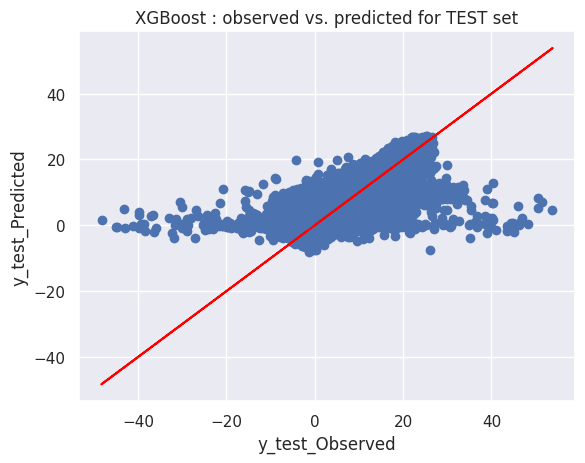

In [97]:
show_scatter_test(y_test, xgb_y_test_predicted, "XGBoost")

## MLP

In [98]:
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
import warnings
warnings.filterwarnings("ignore")

In [99]:
#mlp_X_train, mlp_X_test, mlp_y_train, mlp_y_test, mlp_scaler = get_train_test_split(df, 0.3, 2022, True)

In [ ]:
mlp_model = MLPRegressor(learning_rate_init=0.01, batch_size=32, max_iter=200).fit(X_train, y_train)

In [101]:
# Cross Validation Results

rmse = cross_val_score(mlp_model, mlp_X_train, mlp_y_train, scoring='neg_root_mean_squared_error')
r2 = cross_val_score(mlp_model, mlp_X_train, mlp_y_train, scoring='r2')

#get the mean of each fold 
print("RMSE: %.3f, Standard Deviation : %.3f" % (rmse.mean() * -1, rmse.std())) 
print("R2: %.3f, Standard Deviation : %.3f" % (r2.mean(), r2.std())) 

NameError: name 'mlp_X_train' is not defined

In [ ]:
# Train/Test Results

mlp_y_train_predicted = mlp_model.predict(X_train)
mlp_y_test_predicted = mlp_model.predict(X_test)
mlp_r2, mlp_rmse = calculate_errors(y_train, mlp_y_train_predicted, y_test, mlp_y_test_predicted, "MLP")

In [ ]:
show_scatter_test(y_test, mlp_y_test_predicted, "MLP")

## Model Comparison

In [ ]:
# Predicted Values

models = ["Lasso", "Random Forest", "XGBoost", "MLP"]
test_values = [y_test, y_test, y_test, y_test]
predictions = [lasso_y_test_predicted, rf_y_test_predicted, xgb_y_test_predicted, mlp_y_test_predicted]


fig=plt.figure(figsize=[15,15])

count = 0
for i in range(len(models)):
  count += 1
  plt.subplot(2,2,count)
  show_scatter_test(test_values[i], predictions[i], models[i])

In [ ]:
# Test R2 Score Comparison
r2_scores = [lasso_r2, rf_r2, xgb_r2, mlp_r2]

plt.bar(models, r2_scores)
plt.title("Testing R2 Scores Across Models")

In [ ]:
# RMSE Comparison
rmse_scores = [lasso_rmse, rf_rmse, xgb_rmse, mlp_rmse]

plt.bar(models, rmse_scores)
plt.title("Testing RMSE Scores Across Models")

# 6th Site - ES-LJu

In [53]:
site_id = 'ES-LJu' # 
df = pd.read_csv(data_path + 'data_full_half_hourly_raw_v0_1_' + site_id + '.csv')
df.head()

,TIMESTAMP_START,TIMESTAMP_END,TA_F,TA_F_QC,TA_ERA,SW_IN_POT,SW_IN_F,SW_IN_F_QC,SW_IN_ERA,LW_IN_F,...,NIRv,b1,b2,b3,b4,b5,b6,b7,IGBP,koppen
0,200405260000,200405260030,7.856,0,8.325,0.0,0.0,0,0.0,314.215,...,0.071307,0.1108,0.2183,0.052,0.0884,0.262,0.2695,0.1945,OSH,Temperate
1,200405260030,200405260100,7.650,0,8.180,0.0,0.0,0,0.0,314.215,...,0.071307,0.1108,0.2183,0.052,0.0884,0.262,0.2695,0.1945,OSH,Temperate
2,200405260100,200405260130,7.672,0,8.035,0.0,0.0,0,0.0,328.276,...,0.071307,0.1108,0.2183,0.052,0.0884,0.262,0.2695,0.1945,OSH,Temperate
3,200405260130,200405260200,7.793,0,8.300,0.0,0.0,0,0.0,328.276,...,0.071307,0.1108,0.2183,0.052,0.0884,0.262,0.2695,0.1945,OSH,Temperate
4,200405260200,200405260230,7.638,0,8.565,0.0,0.0,0,0.0,339.403,...,0.071307,0.1108,0.2183,0.052,0.0884,0.262,0.2695,0.1945,OSH,Temperate


In [54]:
target = 'GPP_NT_VUT_REF'
features = ['year','TA_ERA','SW_IN_ERA','P_ERA','VPD_ERA','b1','b2','b3','b4','b5','b6','b7','NDVI','EVI','NIRv']
# and categorical features: IGBP and koppen

df['datetime'] = pd.to_datetime(df['TIMESTAMP_START'])
df = df.set_index('datetime')

In [55]:
# One hot encoding categorical variables: IGBP and Koppen
df_ohe = df[[target, 'IGBP', 'koppen'] + features]

categorical_columns = ['IGBP', 'koppen']
for col in categorical_columns:
    col_ohe = pd.get_dummies(df[col], prefix=col)
    df_ohe = pd.concat((df_ohe, col_ohe), axis=1).drop(col, axis=1)

df_ohe.columns

Index(['GPP_NT_VUT_REF', 'year', 'TA_ERA', 'SW_IN_ERA', 'P_ERA', 'VPD_ERA',
       'b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7', 'NDVI', 'EVI', 'NIRv',
       'IGBP_OSH', 'koppen_Temperate'],
      dtype='object')

In [56]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    return df

In [57]:
# clean the data.
df = clean_dataset(df_ohe)

In [58]:
# test train split grouped by SiteID, year, month
from sklearn.model_selection import GroupShuffleSplit 

splitter = GroupShuffleSplit(test_size=0.3, n_splits=2, random_state = 42)
split = splitter.split(df, groups=df['year'])
train_inds, test_inds = next(split)

train_df = df.iloc[train_inds]
test_df = df.iloc[test_inds]

In [59]:
X_train = train_df.drop([target, 'year'], axis = 1)
X_train.head(2)

y_train = train_df[target]
y_train.head(2)

X_test = test_df.drop([target, 'year'], axis = 1)
X_test.head(2)

y_test = test_df[target]
y_test.head(2)

datetime
1970-01-01 00:03:20.601010000    0.246177
1970-01-01 00:03:20.601010030    0.246177
Name: GPP_NT_VUT_REF, dtype: float64

## Lasso

In [60]:
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=2022)

lasso_model = LassoCV(cv = kf, alphas=np.linspace(0.001, 10, 100), max_iter = 10000)
lasso_model.fit(X_train, y_train)
print('Lasso Model Optimal Alpha: ', lasso_model.alpha_)

Lasso Model Optimal Alpha:  0.001


In [61]:
# Cross Validation Results

rmse = cross_val_score(lasso_model, X_train, y_train, scoring='neg_root_mean_squared_error', cv = kf)
r2 = cross_val_score(lasso_model, X_train, y_train, scoring='r2', cv = kf)

#get the mean of each fold 
print("RMSE: %.3f, Standard Deviation : %.3f" % (rmse.mean() * -1, rmse.std())) 
print("R2: %.3f, Standard Deviation : %.3f" % (r2.mean(), r2.std())) 

RMSE: 1.038, Standard Deviation : 0.007
R2: 0.209, Standard Deviation : 0.008


In [62]:
# Test Results

lasso_y_train_predicted = lasso_model.predict(X_train)
lasso_y_test_predicted = lasso_model.predict(X_test)
lasso_r2, lasso_rmse = calculate_errors(y_train, lasso_y_train_predicted, y_test, lasso_y_test_predicted, "Lasso")

The R2 score of Lasso is: 0.18524465264851175
The RMSE of predicting the TRAINING set of Lasso is: 1.0380205552615087
The RMSE of predicting the TESTING set of Lasso is: 0.9742091139809026
The bias of predicting the TRAINING set of Lasso is: -2.0516152139367665e-16
The bias of predicting the TESTING set of Lasso is: -0.05225517252724709


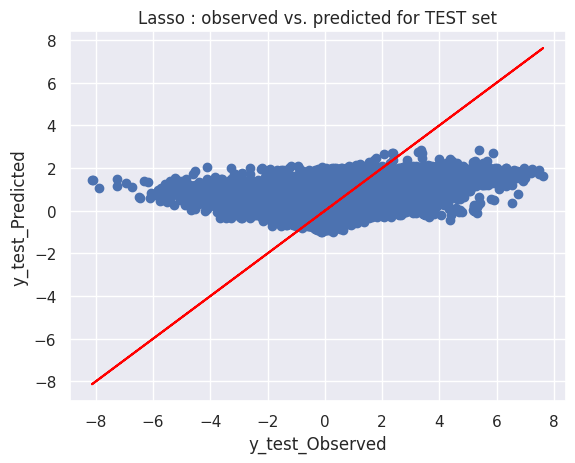

In [63]:
show_scatter_test(y_test, lasso_y_test_predicted, "Lasso")

## SVM

In [ ]:
# NOTE: TAKES A LONG TIME TO RUN

# defining parameter range
svm_param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001],
              'kernel': ['rbf']} 
  
svm = SVR()
svm_random = RandomizedSearchCV(estimator = svm, param_distributions = svm_param_grid, 
                                scoring='neg_mean_squared_error', n_iter = 5, cv = kf, verbose=2, 
                                random_state=2022, n_jobs = -1)
# Fit the random search model
svm_random.fit(X_train, y_train)
# Print best parameters after tuning
print('SVM Best Parameters: ', svm_random.best_params_)

In [ ]:
# Model with Cross Validated Hyperparameters
svm_model = SVR(kernel = 'rbf', gamma = 0.1, C = 10)
svm_model.fit(X_train, y_train)

In [ ]:
# Cross Validation Results

rmse = cross_val_score(svm_model, X_train, y_train, scoring='neg_root_mean_squared_error', cv = kf)
r2 = cross_val_score(svm_model, X_train, y_train, scoring='r2', cv = kf)

#get the mean of each fold 
print("RMSE: %.3f, Standard Deviation : %.3f" % (rmse.mean() * -1, rmse.std())) 
print("R2: %.3f, Standard Deviation : %.3f" % (r2.mean(), r2.std()))

In [ ]:
# Test Results
svm_y_train_predicted = svm_model.predict(X_train)
svm_y_test_predicted = svm_model.predict(X_test)
calculate_errors(y_train, svm_y_train_predicted, y_test, svm_y_test_predicted, "SVM")

In [ ]:
show_scatter_test(y_test, svm_y_test_predicted, "SVM")

## Random Forest

In [64]:
# Number of trees in random forest
n_estimators = [25, 50, 75, 100, 150, 200]
# Number of features to consider at every split
max_features = ['auto', 'sqrt', 0.1, 0.5, 1.0]
# Maximum number of levels in tree
max_depth = [3, 4, 5, 6]
# Minimum number of samples required to split a node
min_samples_split = [2,3,4,5,6]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2,3,4,5,6]
# Method of selecting samples for training each tree
bootstrap = [True, False]


# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestRegressor()
# Random search of parameters, using 5 fold cross validation, search across 10 different combinations
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, 
                               scoring='neg_mean_squared_error',n_iter = 10, cv = kf, verbose=2, 
                               random_state=2022, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)
# Print best parameters after tuning
print('Random Forest Best Parameters: ')
rf_random.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/global/scratch/users/yaqiantang/conda/ml/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/global/scratch/users/yaqiantang/conda/ml/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/global/scratch/users/yaqiantang/conda/ml/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_feat

Random Forest Best Parameters: 


{'n_estimators': 200,
 'min_samples_split': 6,
 'min_samples_leaf': 6,
 'max_features': 0.5,
 'max_depth': 6,
 'bootstrap': True}

[CV] END bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=  10.5s
[CV] END bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=  10.6s
[CV] END bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=  10.7s
[CV] END bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=  10.8s
[CV] END bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=  11.1s
[CV] END bootstrap=False, max_depth=5, max_features=0.5, min_samples_leaf=5, min_samples_split=3, n_estimators=50; total time=  11.6s
[CV] END bootstrap=False, max_depth=5, max_features=0.5, min_samples_leaf=5, min_samples_split=3, n_estimators=50; total time=  11.8s
[CV] END bootstrap=True, max_depth=5, max_features=0.5, m

In [ ]:
rf_model = RandomForestRegressor(n_estimators=200, min_samples_split=6, min_samples_leaf=6, 
                                 max_features=0.5, max_depth = 6, bootstrap = True)
rf_model.fit(X_train, y_train)

In [ ]:
# Cross Validation Results

rmse = cross_val_score(rf_model, X_train, y_train, scoring='neg_root_mean_squared_error', cv = kf)
r2 = cross_val_score(rf_model, X_train, y_train, scoring='r2', cv = kf)

#get the mean of each fold 
print("RMSE: %.3f, Standard Deviation : %.3f" % (rmse.mean() * -1, rmse.std())) 
print("R2: %.3f, Standard Deviation : %.3f" % (r2.mean(), r2.std())) 

In [ ]:
# Train/Test Results

rf_y_train_predicted = rf_model.predict(X_train)
rf_y_test_predicted = rf_model.predict(X_test)
rf_r2, rf_rmse = calculate_errors(y_train, rf_y_train_predicted, y_test, rf_y_test_predicted, 'RF')

In [ ]:
show_scatter_test(y_test, rf_y_test_predicted, "Random Forest")

## XGBoost

In [ ]:
xgb_param_grid = { 'max_depth': [3, 5, 6, 10], 
                  'min_child_weight': [1, 3, 5, 7],
                  'learning_rate': [0.01, 0.1, 0.2, 0.3],
                  'subsample': np.arange(0.5, 1.0, 0.1),
                  'colsample_bytree': np.arange(0.4, 1.0, 0.1),
                  'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
                  'n_estimators': [50, 100, 150, 200, 250]}

xgbr = XGBRegressor()
xgb_random = RandomizedSearchCV(estimator=xgbr, param_distributions=xgb_param_grid, 
                                scoring='neg_mean_squared_error', n_iter=10, cv = kf, verbose=2, 
                                random_state=2022, n_jobs = -1)
xgb_random.fit(X_train, y_train)
print("XGBoost Best Parameters: ")
xgb_random.best_params_

In [ ]:
xgb_model = XGBRegressor(subsample = 0.8, n_estimators = 150, max_depth = 6, min_child_weight = 7,
                         learning_rate = 0.1, colsample_bytree = 0.9, colsample_bylevel = 0.7,
                         objective = 'reg:squarederror')
xgb_model.fit(X_train, y_train)

In [ ]:
# Cross Validation Results

rmse = cross_val_score(xgb_model, X_train, y_train, scoring='neg_root_mean_squared_error', cv = kf)
r2 = cross_val_score(xgb_model, X_train, y_train, scoring='r2', cv = kf)

#get the mean of each fold 
print("RMSE: %.3f, Standard Deviation : %.3f" % (rmse.mean() * -1, rmse.std())) 
print("R2: %.3f, Standard Deviation : %.3f" % (r2.mean(), r2.std()))

In [ ]:
#Train/Test Results

xgb_y_train_predicted = xgb_model.predict(X_train)
xgb_y_test_predicted = xgb_model.predict(X_test)
xgb_r2, xgb_rmse = calculate_errors(y_train, xgb_y_train_predicted, y_test, xgb_y_test_predicted, "XGBoost")

In [ ]:
show_scatter_test(y_test, xgb_y_test_predicted, "XGBoost")

## MLP

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
import warnings
warnings.filterwarnings("ignore")

In [ ]:
mlp_X_train, mlp_X_test, mlp_y_train, mlp_y_test, mlp_scaler = get_train_test_split(df, 0.3, 2022, True)

In [ ]:
mlp_model = MLPRegressor(learning_rate_init=0.01, batch_size=32, max_iter=200).fit(mlp_X_train, mlp_y_train)

In [ ]:
# Cross Validation Results

rmse = cross_val_score(mlp_model, mlp_X_train, mlp_y_train, scoring='neg_root_mean_squared_error')
r2 = cross_val_score(mlp_model, mlp_X_train, mlp_y_train, scoring='r2')

#get the mean of each fold 
print("RMSE: %.3f, Standard Deviation : %.3f" % (rmse.mean() * -1, rmse.std())) 
print("R2: %.3f, Standard Deviation : %.3f" % (r2.mean(), r2.std())) 

In [ ]:
# Train/Test Results

mlp_y_train_predicted = mlp_model.predict(mlp_X_train)
mlp_y_test_predicted = mlp_model.predict(mlp_X_test)
mlp_r2, mlp_rmse = calculate_errors(mlp_y_train, mlp_y_train_predicted, mlp_y_test, mlp_y_test_predicted, "MLP")

In [ ]:
show_scatter_test(mlp_y_test, mlp_y_test_predicted, "MLP")

# Model Comparison

In [ ]:
# Predicted Values

models = ["Lasso", "Random Forest", "XGBoost", "MLP"]
test_values = [y_test, y_test, y_test, mlp_y_test]
predictions = [lasso_y_test_predicted, rf_y_test_predicted, xgb_y_test_predicted, mlp_y_test_predicted]


fig=plt.figure(figsize=[15,15])

count = 0
for i in range(len(models)):
  count += 1
  plt.subplot(2,2,count)
  show_scatter_test(test_values[i], predictions[i], models[i])

In [ ]:
# Test R2 Score Comparison
r2_scores = [lasso_r2, rf_r2, xgb_r2, mlp_r2]

plt.bar(models, r2_scores)
plt.title("Testing R2 Scores Across Models")

In [ ]:
# RMSE Comparison
rmse_scores = [lasso_rmse, rf_rmse, xgb_rmse, mlp_rmse]

plt.bar(models, rmse_scores)
plt.title("Testing RMSE Scores Across Models")